In [21]:
import tensorflow as tf
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [22]:
import os

dataset_path = "/kaggle/input/chest-xray-pneumonia"

print("Conteúdo do dataset:", os.listdir(dataset_path))

for folder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(subfolder_path):
        print(f"\nSubdiretório: {folder}")
        print(os.listdir(subfolder_path))


Conteúdo do dataset: ['chest_xray']

Subdiretório: chest_xray
['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [2]:
import os

base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

datasets = ['train', 'test', 'val']
classes = ['NORMAL', 'PNEUMONIA']

for dataset in datasets:
    print(f"\n {dataset.upper()} SET:")
    for label in classes:
        path = os.path.join(base_dir, dataset, label)
        num_images = len(os.listdir(path))
        print(f"  - {label}: {num_images} imagens")



📂 TRAIN SET:
  - NORMAL: 1341 imagens
  - PNEUMONIA: 3875 imagens

📂 TEST SET:
  - NORMAL: 234 imagens
  - PNEUMONIA: 390 imagens

📂 VAL SET:
  - NORMAL: 8 imagens
  - PNEUMONIA: 8 imagens


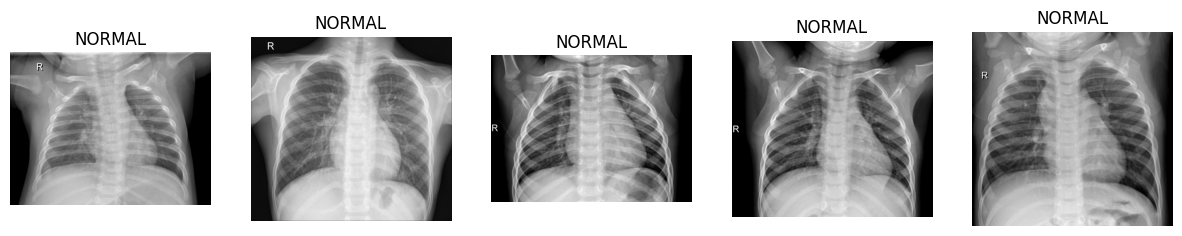

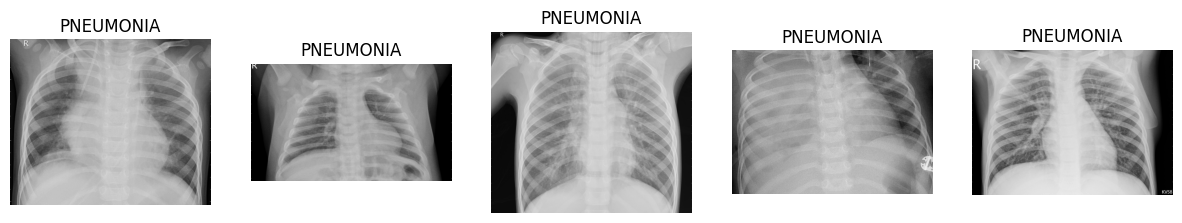

In [3]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_images(directory, label, num_images=5):
    folder_path = os.path.join(directory, label)
    images = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis("off")
    plt.show()

train_path = os.path.join(base_dir, "train")
plot_images(train_path, "NORMAL")
plot_images(train_path, "PNEUMONIA")


In [25]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/"

train_generator = train_datagen.flow_from_directory(
    dataset_path + "train/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    dataset_path + "val/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    dataset_path + "test/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 590ms/step - accuracy: 0.6979 - loss: 0.6061 - val_accuracy: 0.5000 - val_loss: 0.7569
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 567ms/step - accuracy: 0.7511 - loss: 0.5002 - val_accuracy: 0.5625 - val_loss: 0.8698
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 566ms/step - accuracy: 0.7672 - loss: 0.4584 - val_accuracy: 0.5625 - val_loss: 0.7361
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 565ms/step - accuracy: 0.7880 - loss: 0.4431 - val_accuracy: 0.5625 - val_loss: 0.7326
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 571ms/step - accuracy: 0.7908 - loss: 0.4263 - val_accuracy: 0.5625 - val_loss: 0.9210
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 568ms/step - accuracy: 0.7870 - loss: 0.4228 - val_accuracy: 0.5625 - val_loss: 0.8946
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 566ms/step - accuracy: 0.7967 - loss: 0.4117 - val_accuracy: 0.6250 - val_loss: 0.7553
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 568ms/step - accuracy: 0.8088 - loss: 0.3971 - va

In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🔍 Acurácia no conjunto de teste com ResNet50: {test_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.7603 - loss: 0.4715

🔍 Acurácia no conjunto de teste com ResNet50: 76.12%


In [ ]:
from sklearn.metrics import classification_report
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names =["NORMAL", "PNEUMONIA"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


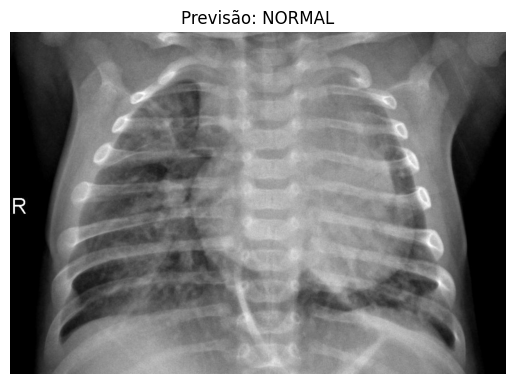

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

test_image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

img = cv2.imread(test_image_path)
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
predicted_label = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"

plt.imshow(cv2.imread(test_image_path), cmap='gray')
plt.title(f"Previsão: {predicted_label}")
plt.axis("off")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step


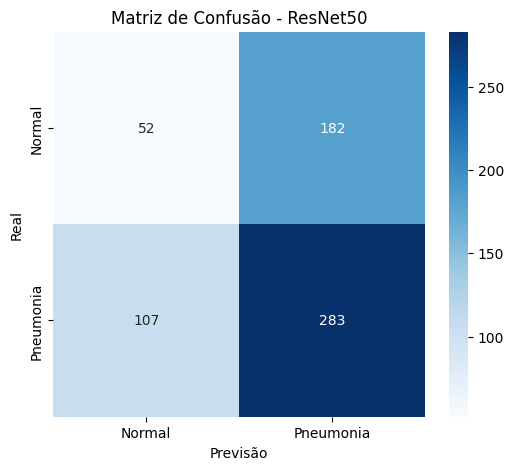

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão - ResNet50")
plt.show()

In [31]:
model.save("modelo_pneumonia_resnet50.h5")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [32]:
from tensorflow.keras.models import load_model

modelo_carregado = load_model("modelo_pneumonia_resnet50.h5")
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [35]:
base_model = model.layers[0]

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Fine-Tuning pronto!")

Fine-Tuning pronto!


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

EPOCHS_FINE_TUNE = 10

history_fine = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 628ms/step - accuracy: 0.8118 - loss: 0.6869 - val_accuracy: 0.7500 - val_loss: 0.5172 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 578ms/step - accuracy: 0.8959 - loss: 0.2445 - val_accuracy: 0.5000 - val_loss: 3.9192 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 581ms/step - accuracy: 0.9138 - loss: 0.2209 - val_accuracy: 0.8750 - val_loss: 0.4465 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 581ms/step - accuracy: 0.9209 - loss: 0.1969 - val_accuracy: 0.7500 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 577ms/step - accuracy: 0.9257 - loss: 0.1910 - val_accuracy: 0.5000 - val_loss: 29.5655 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 584ms/step - accuracy: 0.9248 - loss: 0.1888 - val_accuracy: 0.5000 - val_loss: 4.0389 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 

In [37]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Acurácia no conjunto de teste após Fine-Tuning: {test_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8607 - loss: 0.3400

 Acurácia no conjunto de teste após Fine-Tuning: 87.02%


In [ ]:
from sklearn.metrics import classification_report
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names =["NORMAL", "PNEUMONIA"]))

In [38]:
model.save("modelo_pneumonia_resnet50_finetuned.h5")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step


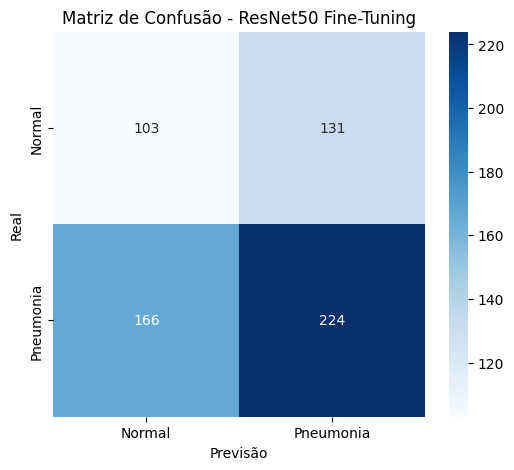

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão - ResNet50 Fine-Tuning")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


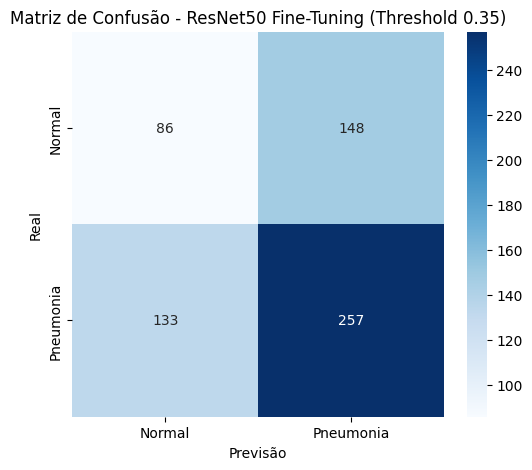

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.35).astype(int)

cm_adjusted = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_adjusted, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão - ResNet50 Fine-Tuning (Threshold 0.35)")
plt.show()


In [45]:
model.save("modelo_pneumonia_resnet50_finetuned_threshold_035.h5")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!
